In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torchvision
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

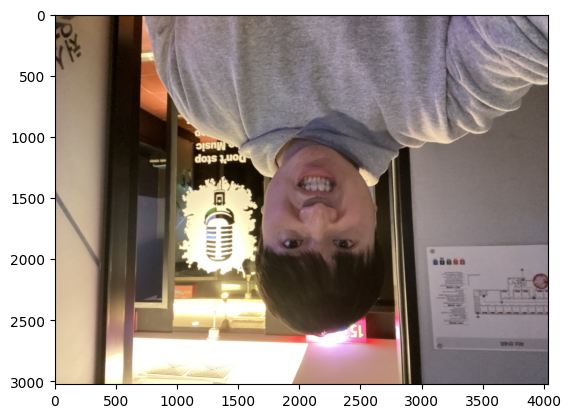

Image Size: (3024, 4032, 3)


In [ ]:
import os

origin_image = "/content/drive/MyDrive/ai_data/240216/selected_images_0.01/images/anger/007f299267a9d6a145f627e9993aeae4e8323652785a2f4d1b896f6489d3acc0_│▓_30_║╨│ы_┐└╢Ї&░°┐м╜├╝│_20201202204109-005-019.jpg"
img = plt.imread(origin_image)
img_array = np.array(img)

# 이미지 출력
plt.imshow(img)
plt.show()
print(f"Image Size: {img.shape}") # (width, height, channels)

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.14 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/225.8 GB disk)


In [ ]:
from ultralytics import YOLO
pretrained_path = "/content/drive/MyDrive/ai_data/yolov8n-face.pt"
model = YOLO(pretrained_path)

In [ ]:
# inference 테스트 - 이미지 한장
source = origin_image
results = model.predict(source, imgsz = 224)
# Process results list
for result in results:
    boxes = result.boxes.xywh  # Boxes object for bounding box outputs
    boxes_norm = result.boxes.xywhn
    boxes_xyxy = result.boxes.xyxy
    origin_img_array = result.orig_img
    result.save_crop(save_dir="/content", file_name="cropped.jpg")
    result.save(filename='result_test.jpg')  # save to disk


image 1/1 /content/drive/MyDrive/ai_data/240216/selected_images_0.01/images/anger/007f299267a9d6a145f627e9993aeae4e8323652785a2f4d1b896f6489d3acc0_│▓_30_║╨│ы_┐└╢Ї&░°┐м╜├╝│_20201202204109-005-019.jpg: 192x224 1 face, 144.3ms
Speed: 16.4ms preprocess, 144.3ms inference, 26.0ms postprocess per image at shape (1, 3, 192, 224)


In [ ]:
print(boxes)
print(boxes_norm)

tensor([[2149.5000, 1358.5000,  909.0000, 1147.0000]])
tensor([[0.5331, 0.4492, 0.2254, 0.3793]])


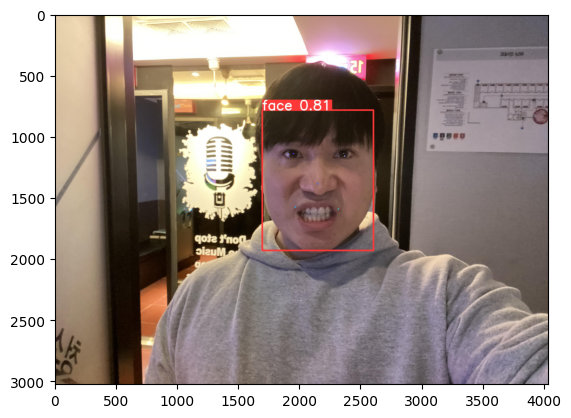

In [ ]:
result_img = "/content/result_test.jpg"
img = plt.imread(result_img)
img_array = np.array(img) # 텐서화랑 비슷한 과정 (취향)

# 이미지 출력
plt.imshow(img)

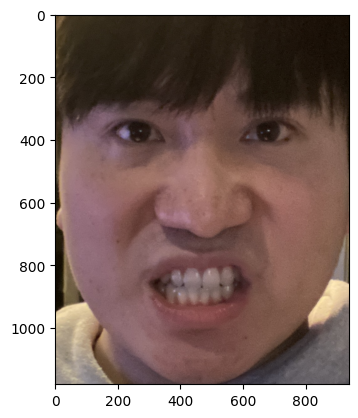

In [ ]:
result_img = "/content/face/cropped.jpg.jpg"
img = plt.imread(result_img)
img_array = np.array(img) # 텐서화랑 비슷한 과정 (취향)

# 이미지 출력
plt.imshow(img)

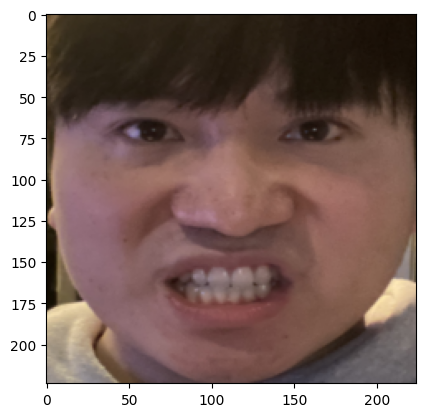

In [ ]:
from PIL import Image
img_pil = Image.fromarray(img_array)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Apply the transformations
resized_face = transform(img_pil)
plt.imshow(resized_face.permute(1, 2, 0).numpy())

이렇게 crop한 이미지를 그냥 resize하게 되면 비율이 깨지는 문제가 발생한다. 따라서 crop한 이미지의 원래 비율은 유지한 채로, 사이즈를 조정하고 여백에는 black pixels을 추가할 수 있다.

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def resize_with_padding(cropped_img_array, target_size):
    """ Resize an image to a target size using padding
    cropped_img_array: image array
    target_size: (width, height)
    return: resized image array
    """
    face_pil = Image.fromarray(cropped_img_array)
    original_size = face_pil.size
    # Calculate the aspect ratio
    aspect_ratio = original_size[0] / original_size[1]  # width / height
    target_aspect_ratio = target_size[0] / target_size[1]  # width / height

    # Calculate the new size with padding
    if aspect_ratio > target_aspect_ratio:
        new_width = int(target_size[0])
        new_height = int(target_size[0] / aspect_ratio)
    else:
        new_width = int(target_size[1] * aspect_ratio)
        new_height = int(target_size[1])

    resized_image = face_pil.resize((new_width, new_height), Image.BICUBIC) # 1) resize
    padded_image = Image.new("RGB", target_size, (0, 0, 0)) # 2) create an empty black canvas with target size
    paste_position = ((target_size[0] - new_width) // 2, (target_size[1] - new_height) // 2) # 3) get a position to paste the resized image
    padded_image.paste(resized_image, paste_position) # 4) paste image to black canvas

    return np.array(padded_image) # return image array

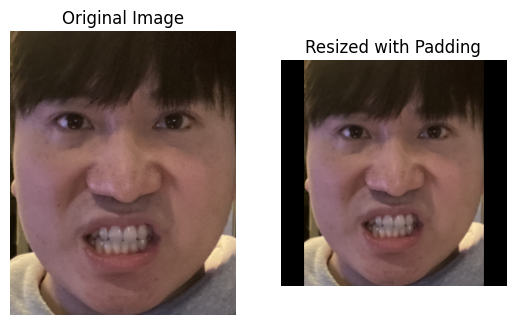

In [ ]:
target_size = (224, 224)

# Resize the image with padding
resized_and_padded_face = resize_with_padding(img_array, target_size)

# Display
plt.subplot(1, 2, 1)
plt.imshow(img_array)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(resized_and_padded_face)
plt.title("Resized with Padding")
plt.axis("off")

plt.show()


### (뒤늦게 찾은 ultarlytics 함수) crop with pad
- 얼굴 외 부분을 일부 포함 시켜서 비율을 맞춰준다.

In [ ]:
from ultralytics.utils.plotting import save_one_box
cropped_im = save_one_box(boxes_xyxy, origin_img_array, square=True)

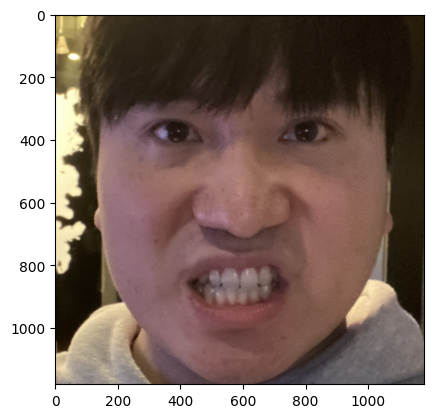

In [ ]:
plt.imshow(cropped_im)

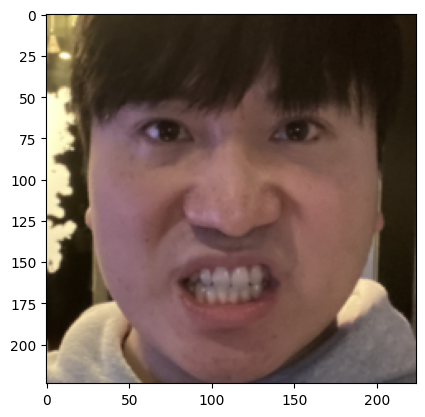

In [ ]:
from PIL import Image
img_pil = Image.fromarray(cropped_im)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Apply the transformations
resized_face = transform(img_pil)
plt.imshow(resized_face.permute(1, 2, 0).numpy())

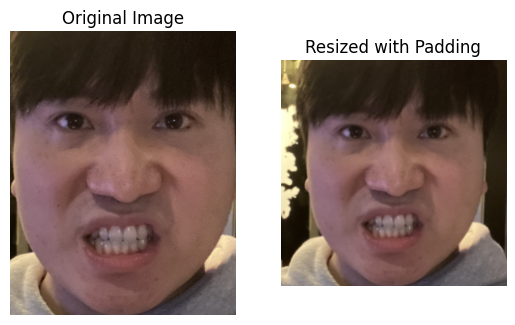

In [ ]:
# Display
plt.subplot(1, 2, 1)
plt.imshow(img_array)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(resized_face.permute(1, 2, 0).numpy())
plt.title("Resized with Padding")
plt.axis("off")

plt.show()

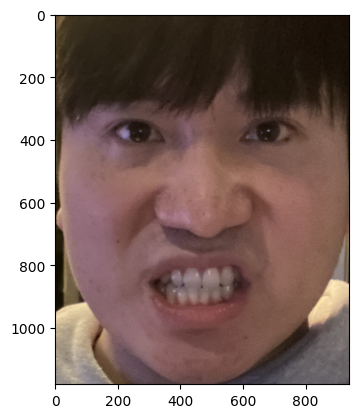

In [ ]:
# YOLO 함수 사용하되 저장 안하고 array만 내보내기
cropped_im = save_one_box(boxes_xyxy, origin_img_array, square=False, save=False)
plt.imshow(cropped_im)